# Danish Library Exploratory Analysis
By Kasper Primdal Lauritzen

Data from [DBC](http://www.dbc.dk/news/hack-dbcs-data)

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

I want to read a rather large data set, but the exploratory analysis is better done on a small subset of the full data set. We'll use 1000000 records of the full set initially

In [99]:
cols = ["user_id", "library_id", "material_id", "gender", "birth_year", "date"]
small_lending = pd.read_csv("udlånsdata.csv.gz", parse_dates=[4, 5],
                            na_values="", names=cols, header=0, nrows=100000)

In [100]:
lending = pd.read_csv("udlånsdata.csv.gz", parse_dates=[4, 5],
                            na_values="", names=cols, header=0)
small_lending = lending

In [101]:
materials = pd.read_csv("materialedata.csv.gz", na_values="", dtype=str,
                       index_col='materiale_id')

So how does this look?

In [ ]:
print small_lending.head()
print materials.head()

Translation note: `k` == female, `m` == male.


Lets get the age of each user at the time of the recording. Pandas uses timedelta

In [103]:
age_in_days = small_lending.date - small_lending.birth_year
age_in_years = age_in_days.apply(lambda x: round(x / np.timedelta64(365, 'D')))
small_lending['age'] = age_in_years

We can also check add a small function that calculates the age bracket of the user for each lending event

In [104]:
def add_decade(age):
    return age // 10 * 10
small_lending['age_decade'] = small_lending.age.apply(add_decade)
small_lending.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59453766 entries, 0 to 59453765
Data columns (total 8 columns):
user_id        int64
library_id     int64
material_id    object
gender         object
birth_year     datetime64[ns]
date           datetime64[ns]
age            float64
age_decade     float64
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 4.0+ GB


In [105]:
small_lending.head()

,user_id,library_id,material_id,gender,birth_year,date,age,age_decade
0,1,830060,870970-basis:27094783,k,1994-01-01,2015-03-05,21,20
1,2,830060,870970-basis:26338948,k,1989-01-01,2015-02-17,26,20
2,3,830060,870970-basis:29819084,k,1992-01-01,2015-03-10,23,20
3,4,830060,870970-basis:24417468,k,1985-01-01,2015-02-18,30,30
4,5,830060,870970-basis:27435777,k,1980-01-01,2015-03-12,35,30


# Gender differences

OK, lets do some summary statistics on this. We'll group it by gender and age, and see how many transactions was made for each of these combinations.

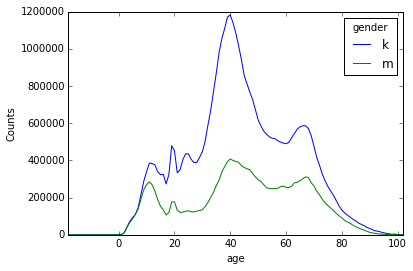

In [106]:
age_gender = pd.crosstab( small_lending.age, small_lending.gender)
ax = age_gender.plot()
ax.set_ylabel("Counts")

Let's look at the relative frequencies by age.

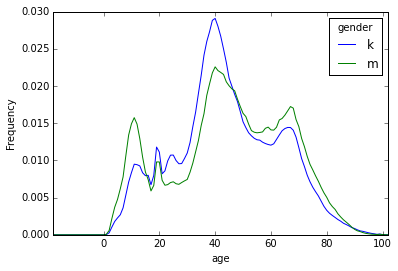

In [107]:
age_gender_pct = age_gender.div(age_gender.sum(0))
ax = age_gender_pct.plot()
ax.set_ylabel("Frequency")

From the figure with absolute counts we can see that after around age 10, women are more likely to use the library (or at least to take out more books) than men. 

# Most popular books

In [108]:
total_records = float(small_lending.count().user_id)
counts = small_lending['material_id'].value_counts()
# Here we have to get the data into the right format to merge
# into materials. That is, both should be pd.DataFrame, and the indicies
# should match up.
counts = pd.Series(counts, name='counts')
counts_df = pd.DataFrame(counts)
counts_df.index.name = 'material_id'
# Now concatenate the two
materials = pd.concat([materials, counts_df], axis=1)

Sort by most popular

In [109]:
materials.sort_values(inplace=True, ascending=False, by='counts')

In [110]:
materials.head()

,dk5,description,creator,subject-phrase,title,type,counts
870970-basis:28511663,"[""sk"",86.0]","Krimi. Carl Mørck, leder af politiets afdeling...",Jussi Adler-Olsen,"[""sk"",""2000-2009"",""politiromaner"",""1980-1989"",...",Journal 64 : krimithriller,book,34518
870970-basis:29494940,"[""sk"",83.0]",E.L. James pseudonym for Erika Leonard,E. L. James,"[""sk"",""USA"",""sex"",""forelskelse"",""sadomasochism...",Fifty shades,book,33851
870970-basis:29754519,"[""sk"",86.0]",NaN,Jussi Adler-Olsen,"[""sk"",""Skønlitteratur""]",Marco effekten : krimithriller,book,32619
870970-basis:25683463,[77.74],NaN,Claus Bue,"[""for 4 år"",""børnefilm"",""for 3 år"",""77.74"",""fo...",Bamses billedbog dvd,movie,29895
870970-basis:29060835,"[""sk"",86.0]",Krimi. Louise Rick er nu leder af Den Særlige ...,Sara Blædel,"[""sk"",""psykisk udviklingshæmmede"",""Skønlittera...",De glemte piger : krimi,book,29781


In [111]:
def counts_per_group(group, key, description):
    counts = group.material_id.value_counts()
    counts = pd.Series(counts, name='counts_{description}_{key}'.format(**locals()))
    counts_df = pd.DataFrame(counts)
    counts_df.index.name = 'material_id'
    return counts_df

def add_counts(grouping):
    global materials
    frames = [materials]
    grouped = small_lending.groupby(grouping)
    for key, group in grouped:
        frame = counts_per_group(group, key, grouping)
        frames.append(frame)
    materials = pd.concat(frames, axis=1)


In [112]:
add_counts('gender')
add_counts('age_decade')

In [113]:
materials.sort_values(by='counts', inplace=True, ascending=False)
materials.head()

,dk5,description,creator,subject-phrase,title,type,counts,counts_gender_k,counts_gender_m,counts_age_decade_-20.0,...,counts_age_decade_10.0,counts_age_decade_20.0,counts_age_decade_30.0,counts_age_decade_40.0,counts_age_decade_50.0,counts_age_decade_60.0,counts_age_decade_70.0,counts_age_decade_80.0,counts_age_decade_90.0,counts_age_decade_100.0
870970-basis:28511663,"[""sk"",86.0]","Krimi. Carl Mørck, leder af politiets afdeling...",Jussi Adler-Olsen,"[""sk"",""2000-2009"",""politiromaner"",""1980-1989"",...",Journal 64 : krimithriller,book,34518,24508,9890,NaN,...,666,1837,3726,7044,6667,7819,4946,1429,149,5
870970-basis:29494940,"[""sk"",83.0]",E.L. James pseudonym for Erika Leonard,E. L. James,"[""sk"",""USA"",""sex"",""forelskelse"",""sadomasochism...",Fifty shades,book,33851,30753,3003,NaN,...,3412,6359,6257,8218,4509,2946,1534,348,30,NaN
870970-basis:29754519,"[""sk"",86.0]",NaN,Jussi Adler-Olsen,"[""sk"",""Skønlitteratur""]",Marco effekten : krimithriller,book,32619,23209,9343,NaN,...,482,1528,3430,6779,6541,7391,4884,1272,146,3
870970-basis:25683463,[77.74],NaN,Claus Bue,"[""for 4 år"",""børnefilm"",""for 3 år"",""77.74"",""fo...",Bamses billedbog dvd,movie,29895,20730,8859,NaN,...,1792,3294,12881,5181,1377,1755,385,14,NaN,NaN
870970-basis:29060835,"[""sk"",86.0]",Krimi. Louise Rick er nu leder af Den Særlige ...,Sara Blædel,"[""sk"",""psykisk udviklingshæmmede"",""Skønlittera...",De glemte piger : krimi,book,29781,23924,5765,NaN,...,597,1048,2499,5291,5732,7370,5178,1663,225,5


TODO: How many books take up the top 10, 25 and 50 % of the lending?

# What books are popular in each demographic?

TODO: Intro

In [ ]:
teen_boys = small_lending[(10 < small_lending.age) & (small_lending.age < 20) & (small_lending.gender == 'm')]

In [ ]:
teen_boys = teen_boys.sort_values('freq', ascending=False)
teen_boys.head()